# 02. Neural Network Classification with PyTorch

Classification is a proble of predicting whether something is one thing or another (there can be multiple things as options). First, import the necessary modules.

In [1]:
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
RANDOM_SEED = 42


## 1. Make classification data and get it ready

In [2]:
n_samples = 1000

# Create circles

X, y = make_circles(n_samples=n_samples, 
                    noise=0.03,
                    random_state=RANDOM_SEED)

In [3]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [4]:
# Make DataFrame of circle data
circles = pd.DataFrame({"X1": X[:,0], 
                        "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


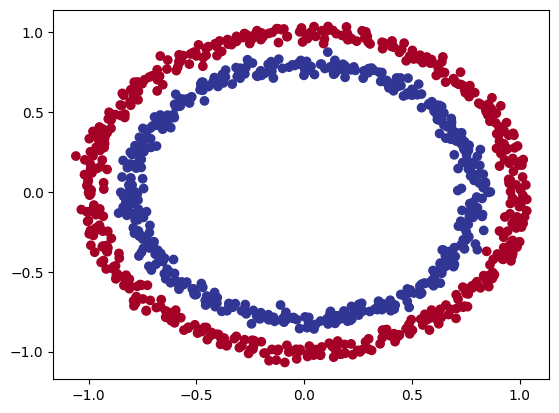

In [5]:
# Visualize
plt.scatter(x=X[:,0], 
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

**Note**: The data we're working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train and test splits

Observe> `torch.float` is an alias for `torch.float32`.

In [7]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5], X.dtype, y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.float32,
 torch.float32)

In [8]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [9]:
len(X_train), len(X_test), len(y_test), len(y_train)

(800, 200, 200, 800)

## 2. Building a model

Let's build a model to classify our blue and red dots. To do so, we want to:
1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [10]:
# Make device agnostic code
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


Now we've setup device agnostic code, let's create a model that:
1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [11]:
# Construct a mdoel

class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,5)        # takes in two features and upscales to five
        self.layer2 = nn.Linear(5,1)        # takes in five features from the previous layer and outputs a single feature (same shape as y)

    def foward(self,x):
        return self.layer2(self.layer1(x))
    
# Instantiate an instance of our model class and send it to the target device
model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
model0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.1396,  0.1900],
                      [ 0.4965, -0.0110],
                      [ 0.4072, -0.2978],
                      [-0.0867, -0.0258],
                      [-0.1555, -0.6351]], device='mps:0')),
             ('layer1.bias',
              tensor([-0.5127,  0.4552,  0.2672,  0.5849, -0.0308], device='mps:0')),
             ('layer2.weight',
              tensor([[0.2499, 0.1101, 0.3365, 0.3893, 0.1636]], device='mps:0')),
             ('layer2.bias', tensor([-0.1205], device='mps:0'))])

In [13]:
## Let's replicate our model above using `nn.Sequential()`
model0 = nn.Sequential(
    nn.Linear(2,5),
    nn.Linear(5,1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Make some predictions (with the untrained model)

with torch.inference_mode():
    untrained_preds = model0(X_test.to(device))

print(f"First 10 predictions: \n{untrained_preds[:10]}")
print(f"First 10 labels: \n{y_test[:10]}")

First 10 predictions: 
tensor([[0.2218],
        [0.1131],
        [0.6275],
        [0.1064],
        [0.8193],
        [0.7515],
        [0.2935],
        [0.4435],
        [0.6188],
        [0.1080]], device='mps:0')
First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss function and optimizer should you use? Again... this is problem specific. 

For example, for regression you might want to use MAE (mean absolute error) or MSE (mean square error).

For classification you might want to use binary cross entropy (BCE) or categorial cross entropy loss.

And for optimizers, two of the most common and useful are SGD and Adam, however, PyTorch has many build-in options!

For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`.

In [15]:
# Setup the loss function

loss_fn = nn.BCEWithLogitsLoss()        # BCEWithLogitsLoss = sigmoid activation function is built-in -> More numerically stable
#loss_fn = nn.BCELoss()                  # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss

optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [16]:
# Calculate accuracy - What percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train our model

To train our model, we're going to need to build a training loop with the following step:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Backpropagation
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits to prediction probabilities to true labels

Our model outputs are going to be **raw logits**.  We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation function (e.g. `sigmoid` for binary classification and `softmax` for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [17]:
# View the first 5 outputs of the forward pass on the test data
model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test.to(device))
y_logits[:5]

tensor([[0.2218],
        [0.1131],
        [0.6275],
        [0.1064],
        [0.8193]], device='mps:0')

In [18]:
# Use the sigmoid activation function on our model logits to turn them into preidction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5]

tensor([[0.5552],
        [0.5283],
        [0.6519],
        [0.5266],
        [0.6941]], device='mps:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [19]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)


### 3.2 Building a training and testing loop

In [20]:
torch.manual_seed(RANDOM_SEED)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training an evaluation loop
for epoch in range(epochs):
    # Activate training mode
    model0.train()

    # 1. Forward pass
    y_logits = model0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate the loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()


    ### Testing
    model0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

        # print out what's happenin'
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.73618 | Accuracy: 50.00% | Test Loss: 0.71792 | Test accuracy: 50.00% 
Epoch: 10 | Loss: 0.71078 | Accuracy: 58.88% | Test Loss: 0.69870 | Test accuracy: 59.50% 
Epoch: 20 | Loss: 0.70224 | Accuracy: 52.75% | Test Loss: 0.69292 | Test accuracy: 53.50% 
Epoch: 30 | Loss: 0.69901 | Accuracy: 50.38% | Test Loss: 0.69119 | Test accuracy: 54.50% 
Epoch: 40 | Loss: 0.69757 | Accuracy: 49.62% | Test Loss: 0.69070 | Test accuracy: 55.50% 
Epoch: 50 | Loss: 0.69676 | Accuracy: 49.00% | Test Loss: 0.69060 | Test accuracy: 54.50% 
Epoch: 60 | Loss: 0.69621 | Accuracy: 49.12% | Test Loss: 0.69062 | Test accuracy: 54.00% 
Epoch: 70 | Loss: 0.69580 | Accuracy: 48.88% | Test Loss: 0.69068 | Test accuracy: 54.00% 
Epoch: 80 | Loss: 0.69545 | Accuracy: 49.00% | Test Loss: 0.69076 | Test accuracy: 54.00% 
Epoch: 90 | Loss: 0.69517 | Accuracy: 49.00% | Test Loss: 0.69085 | Test accuracy: 54.50% 


Our model is not performing very well! Basically as good as a random coin flip.

## 4. Make predictions and evaluate the model

From the metrics it looks like out model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

To do so, we're going to import a function called `plor_decision_boundary()`

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helpers.py").is_file():
    print("helpers.py already exists, skipping download")
else:
    print("Download helper function")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helpers.py", "wb") as f:
        f.write(request.content)

helpers.py already exists, skipping download


/Users/mhehl/Documents/PyTorch - Course/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


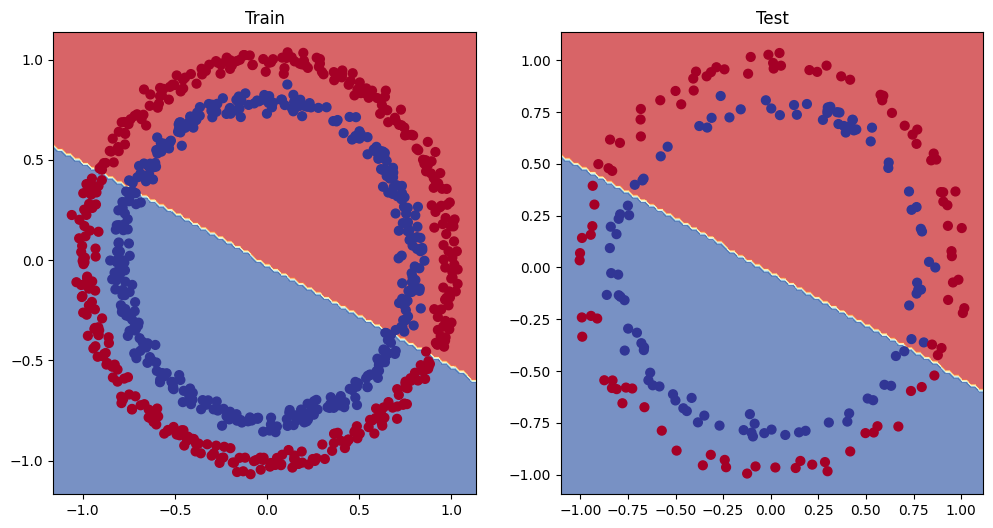

In [22]:
from helpers import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

The decision boundary is just a straight line since we're just concatenating linear layers.

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the arctivation fucntions
* Change the learning rate
* Change the loss function


These options are all from a model's perspective because they deal directly with the model, rather than the data.

And becasue these options are all values we (as machine learning engineers) and data scientists can change, they are referred to as **hyperparameters**.

Let's try to improve our model by:
* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000

In [23]:
class CircleModelV1(nn.Module):

    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # You can achieve speed-ups in PyTorch by calling it all in one line!
        return self.layer3(self.layer2(self.layer1(x)))
    

model1 = CircleModelV1().to(device=device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.01)

In [25]:
torch.manual_seed(RANDOM_SEED)

#Train for longer
epochs = 1000

# Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model1.train()
    # 1. Forward pass
    y_logits = model1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss/acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation
    loss.backward()

    # 5. Optimizer step
    optimizer.step()


    ### Testing
    model1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    
    if epoch % 10 ==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, test accuracy: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 10 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 20 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 30 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 40 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 50 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 60 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 70 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 80 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 90 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 100 | Loss: 0.69396, accuracy: 50.88% | Test loss: 0.69261, test accuracy: 51.00%
Epoch: 110 | Loss: 0.69396, accu

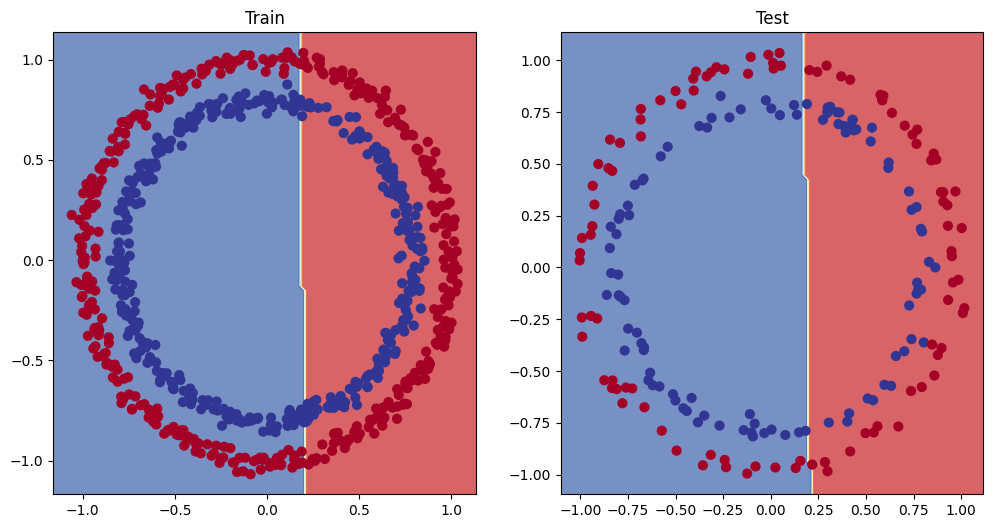

In [26]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

Of course, or model is still just a concatenation of linear layers and hence we have a linear decision boundary.

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [27]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias
print(len(X_regression))

100


In [28]:
# Create train and test splits
train_split = int(len(X_regression) * 0.8)
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check lengths of each
print(len(X_test_regression), len(X_train_regression))

20 80


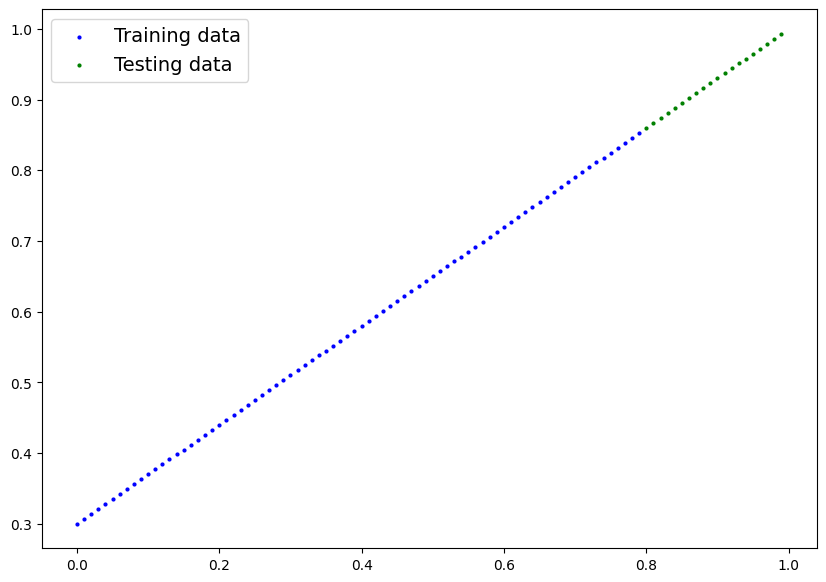

In [29]:
from helpers import plot_predictions

plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression)

### 5.2 Adjust model1 to fit a straight line

In [30]:
model2 = nn.Sequential(
    nn.Linear(1,10),
    nn.Linear(10,10),
    nn.Linear(10,1)
).to(device=device)

model2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
# Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.01)

In [32]:
# Train the model
torch.manual_seed(RANDOM_SEED)
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)


for epoch in range(epochs):
    model2.train()

    y_pred = model2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model2.eval()
    with torch.inference_mode():
        test_pred = model2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happenin'
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {loss:.5f}")
    

Epoch: 0 | Loss: 0.75986 | Test loss: 0.75986
Epoch: 100 | Loss: 0.02858 | Test loss: 0.02858
Epoch: 200 | Loss: 0.02533 | Test loss: 0.02533
Epoch: 300 | Loss: 0.02137 | Test loss: 0.02137
Epoch: 400 | Loss: 0.01964 | Test loss: 0.01964
Epoch: 500 | Loss: 0.01940 | Test loss: 0.01940
Epoch: 600 | Loss: 0.01903 | Test loss: 0.01903
Epoch: 700 | Loss: 0.01878 | Test loss: 0.01878
Epoch: 800 | Loss: 0.01840 | Test loss: 0.01840
Epoch: 900 | Loss: 0.01798 | Test loss: 0.01798


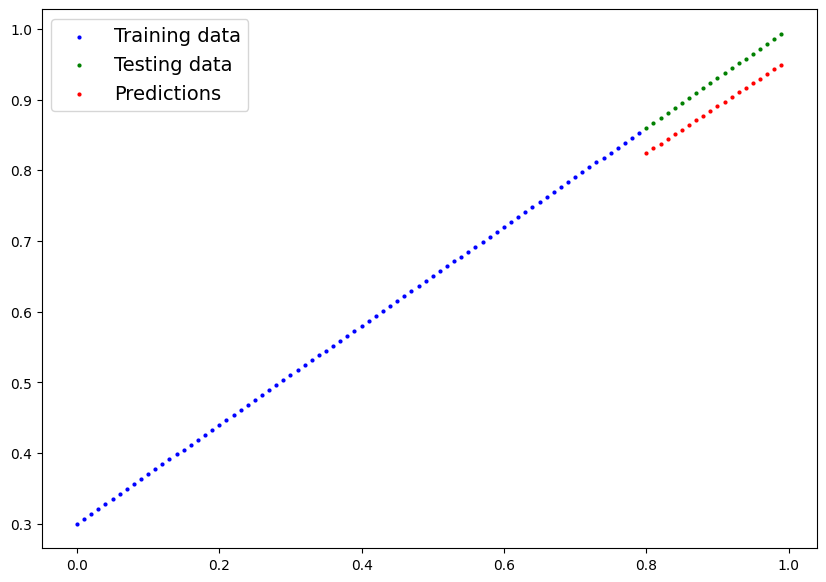

In [33]:
model2.eval()
with torch.inference_mode():
    predictions = model2(X_test_regression)

plot_predictions(X_train_regression.to("cpu"), y_train_regression.to("cpu"), X_test_regression.to("cpu"), y_test_regression.to("cpu"), predictions.to("cpu"))

Our model clearly has some capacity to learn (at least for straight lines!)

## 6. The missing piece: non-linearity

"What patterms could you draw if you were given an infinite amount of straight and non-straight lines?"

Or in machine lkearning terms, an infinite amount (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data



In [34]:
# Make and plot data

n_samples = 1000
X,y = make_circles(n_samples,
                    noise=0.03,
                    random_state=RANDOM_SEED)
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

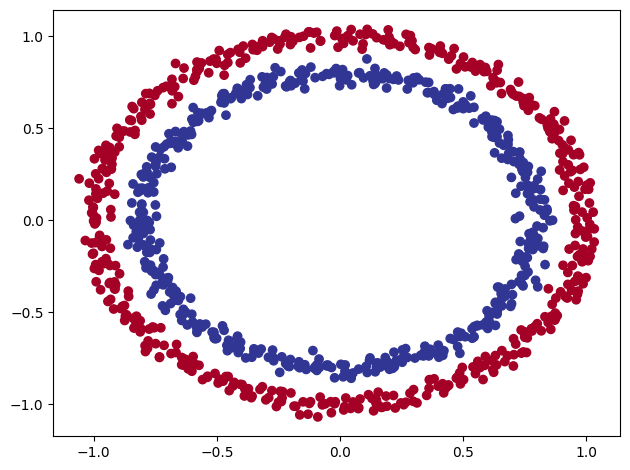

In [35]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.tight_layout()

In [36]:
# Convert data to tensors and then to train and test splits

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Splot into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=RANDOM_SEED)

### 6.2 Building a model with non-linearity

* Linear = straight line
* Non-linear = non-straight line

In [37]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,10)
        self.layer2 = nn.Linear(10,10)
        self.layer3 = nn.Linear(10,1)
        self.relu = nn.ReLU()               # non-linearity


    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [38]:
device

'mps'

In [39]:
model3 = CircleModelV2().to(device)
model3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [41]:
torch.manual_seed(RANDOM_SEED)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
model3.to(device=device)

for epoch in range(epochs):
    model3.eval()
    y_logits = model3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()


    model3.eval()
    with torch.inference_mode():
        test_logits = model3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 0.69295 | Accuracy: 50.00% | Test loss: 0.69319 | Test accuracy: 50.00% 
Epoch: 100 | Loss: 0.69115 | Accuracy: 52.88% | Test loss: 0.69102 | Test accuracy: 52.50% 
Epoch: 200 | Loss: 0.68977 | Accuracy: 53.37% | Test loss: 0.68940 | Test accuracy: 55.00% 
Epoch: 300 | Loss: 0.68795 | Accuracy: 53.00% | Test loss: 0.68723 | Test accuracy: 56.00% 
Epoch: 400 | Loss: 0.68517 | Accuracy: 52.75% | Test loss: 0.68411 | Test accuracy: 56.50% 
Epoch: 500 | Loss: 0.68102 | Accuracy: 52.75% | Test loss: 0.67941 | Test accuracy: 56.50% 
Epoch: 600 | Loss: 0.67515 | Accuracy: 54.50% | Test loss: 0.67285 | Test accuracy: 56.00% 
Epoch: 700 | Loss: 0.66659 | Accuracy: 58.38% | Test loss: 0.66322 | Test accuracy: 59.00% 
Epoch: 800 | Loss: 0.65160 | Accuracy: 64.00% | Test loss: 0.64757 | Test accuracy: 67.50% 
Epoch: 900 | Loss: 0.62362 | Accuracy: 74.00% | Test loss: 0.62145 | Test accuracy: 79.00% 


### 6.4 Evaluating a model trained with non-linear activation functions

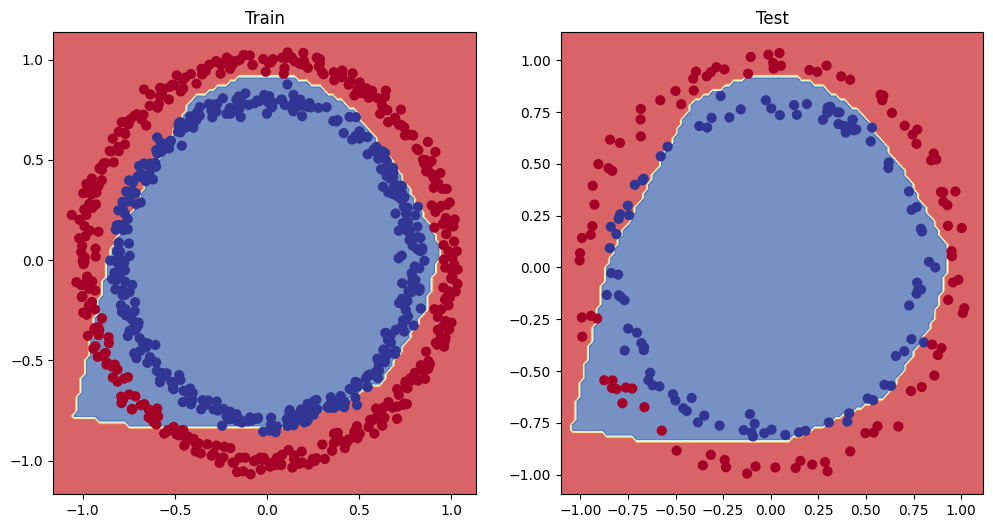

In [42]:
# Make predictions
model3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model3(X_test))).squeeze()

# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

Compare to linear model:

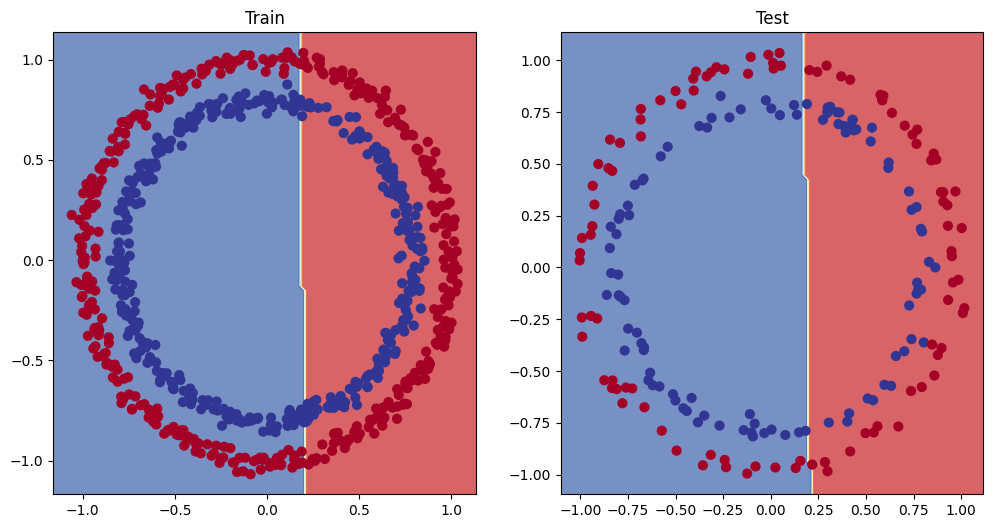

In [43]:
# Plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

## 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tool to discover pattern in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.

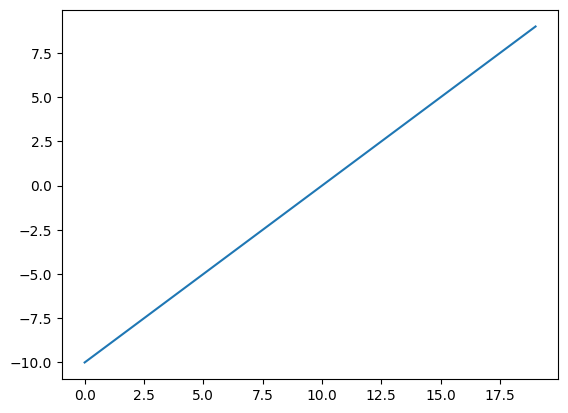

In [44]:
# Create a tensor
A = torch.arange(-10,10,1,dtype=torch.float32)
plt.plot(A)

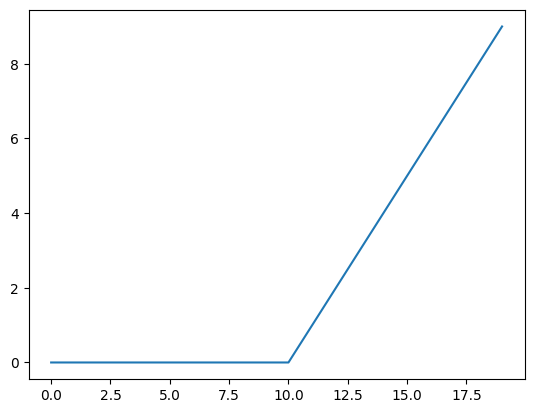

In [45]:
plt.plot(torch.relu(A))

In [46]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)        # inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

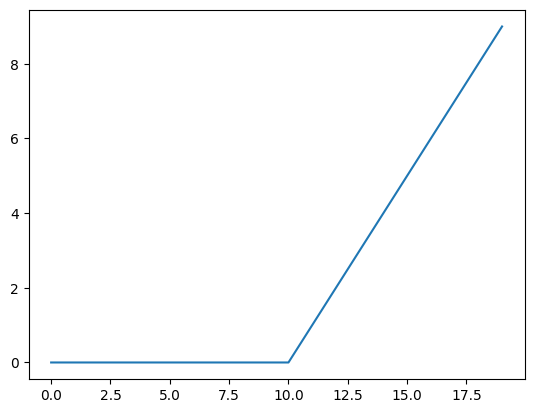

In [47]:
plt.plot(relu(A))

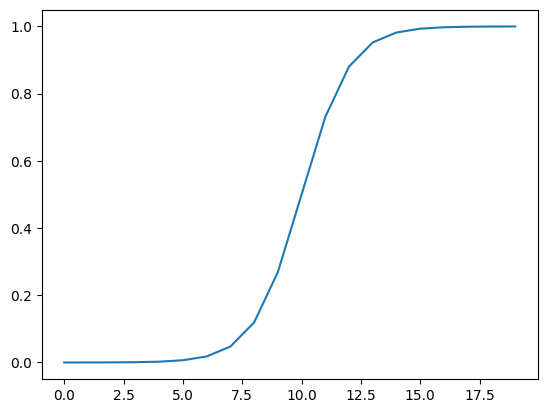

In [48]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(torch.sigmoid(A))

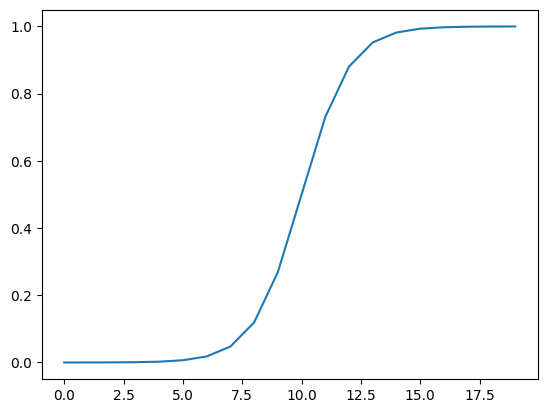

In [49]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multiclass classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud or not fraud)
* Multiclass classification = more than one thingor another (cat vs. dog. vs. chicken)

### 8.1 Creating a toy multiclass dataset

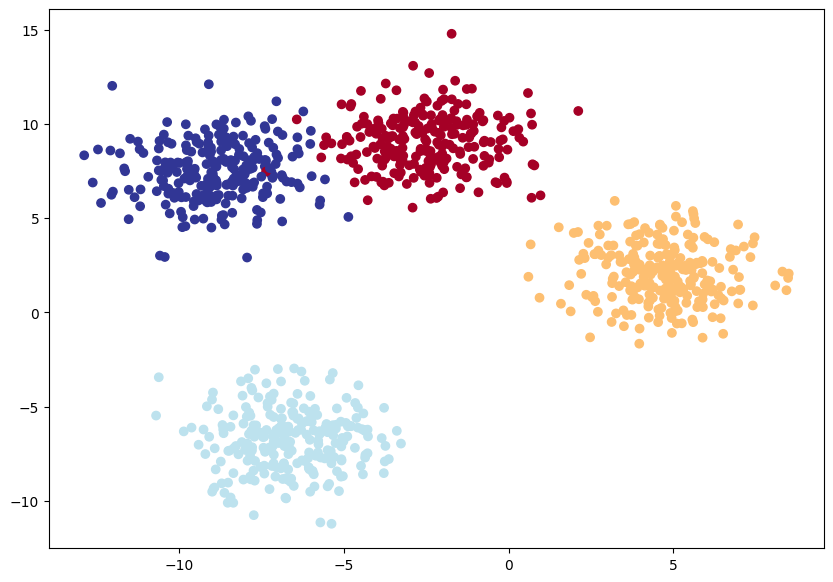

In [50]:
from sklearn.datasets import make_blobs

# Set hyperparameters for the data creation
NUM_CLASSES = 4 
NUM_FEATURES = 2

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multiclass classification model in PyTorch

In [51]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)
    
model4 = BlobModel(input_features=2, output_features=4).to(device=device)
model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [52]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [53]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Create a loss function and an optimizer for a multiclass classification model

In [54]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer for multi-class classification
optimizer = torch.optim.SGD(params=model4.parameters(), lr=0.1)     # learning rate is a hyperparameter you can change

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model we need to convert our model's output (logits) to prediction probabilities and then to prediction labels.

Logits (raw outputs of the model) -> Prediction probabilities (use `torch.softmax`) -> Predictions (take the argmax of the probabilities)

In [55]:
# Let's get some raw outputs of our model (logits)
with torch.inference_mode():
    y_logits = model4(X_blob_test.to(device))

y_logits[:10]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852],
        [ 2.0878, -1.3728,  2.1248,  2.5052],
        [ 1.8310,  0.8851,  2.1674,  0.6006],
        [ 0.1412, -1.4742, -0.0360,  1.0373],
        [ 2.9426,  0.7047,  3.3670,  1.6184],
        [-0.0645, -1.5006, -0.2666,  0.8940]], device='mps:0')

In [56]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951],
        [0.2788, 0.0088, 0.2893, 0.4232],
        [0.3246, 0.1261, 0.4545, 0.0948],
        [0.2229, 0.0443, 0.1867, 0.5461],
        [0.3447, 0.0368, 0.5269, 0.0917],
        [0.2145, 0.0510, 0.1752, 0.5593]], device='mps:0')

In [57]:
# Since those are prediction probabilities, they sum to one
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0')

In [58]:
# Making predictions by taking the argmax
torch.argmax(y_pred_probs[0])
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([3, 3, 2, 1, 3, 3, 2, 3, 2, 3], device='mps:0')

### 8.5 Creating a training loop and testing loop for a multi-class PyTorch model

In [59]:
# Fit the multi-class model to the data
torch.manual_seed(RANDOM_SEED)

# Set the number of epochs
epochs = 100

# Put the data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ## Training
    model4.train()

    y_logits = model4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model4.eval()
    with torch.inference_mode():
        test_logits = model4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, test_pred)

    # Print out what's happenin'
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324 | Accuracy: 65.50% | Test loss: 0.57861 | Test accuracy: 95.50%
Epoch: 10 | Loss: 0.14398 | Accuracy: 99.12% | Test loss: 0.13037 | Test accuracy: 99.00%
Epoch: 20 | Loss: 0.08062 | Accuracy: 99.12% | Test loss: 0.07216 | Test accuracy: 99.50%
Epoch: 30 | Loss: 0.05924 | Accuracy: 99.12% | Test loss: 0.05133 | Test accuracy: 99.50%
Epoch: 40 | Loss: 0.04892 | Accuracy: 99.00% | Test loss: 0.04098 | Test accuracy: 99.50%
Epoch: 50 | Loss: 0.04295 | Accuracy: 99.00% | Test loss: 0.03486 | Test accuracy: 99.50%
Epoch: 60 | Loss: 0.03910 | Accuracy: 99.00% | Test loss: 0.03083 | Test accuracy: 99.50%
Epoch: 70 | Loss: 0.03643 | Accuracy: 99.00% | Test loss: 0.02799 | Test accuracy: 99.50%
Epoch: 80 | Loss: 0.03448 | Accuracy: 99.00% | Test loss: 0.02587 | Test accuracy: 99.50%
Epoch: 90 | Loss: 0.03300 | Accuracy: 99.12% | Test loss: 0.02423 | Test accuracy: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [60]:
# Make predictions
model4.eval()
with torch.inference_mode():
    y_logits = model4(X_blob_test)

# View the first ten predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7643],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5919, -18.5990,  25.5310,  17.5800],
        [  7.3142,   0.7197, -11.2018,  -1.2011]], device='mps:0')

In [61]:
# Go from logits to prediction probabilties to predictions
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred = torch.argmax(y_pred_probs, dim=1)


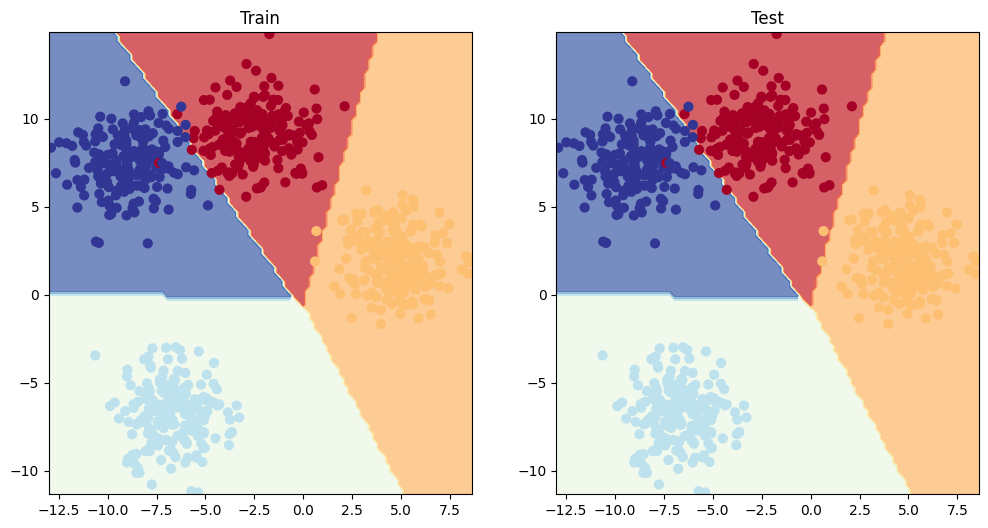

In [62]:
# Visualize
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model4, X_blob_train, y_blob_train)

Observe that our data is linearly seperable. Hence, we could have not used the ReLU activation funciton and obtained the same results! Check it out by commenting out ReLU in the model class and run the same experiments!

# 9. A few more classification metrics (to evaluate our classification models)

* Accuracy - What percentage of samples did we classify right? `torchmetrics.Accuracy()`
* Precision - true_positives / (true_positives + false_positives); `torchmetrics.Precision()` 
* Recall -  true_positives / (true_positives + false_negatives); `torchmetrics.Recall()`
Be aware of Precision/Recall Tradeoff
* F1-Score - Combines precision and recall; `torchmetrics.F1Score()`
* Confusion Matrix - Very helpful with multiclass classification models
* Classification report  

In [63]:
from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task="Multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetric_accuracy(y_pred, y_blob_test)

tensor(0.9950, device='mps:0')

# 10. Exercises

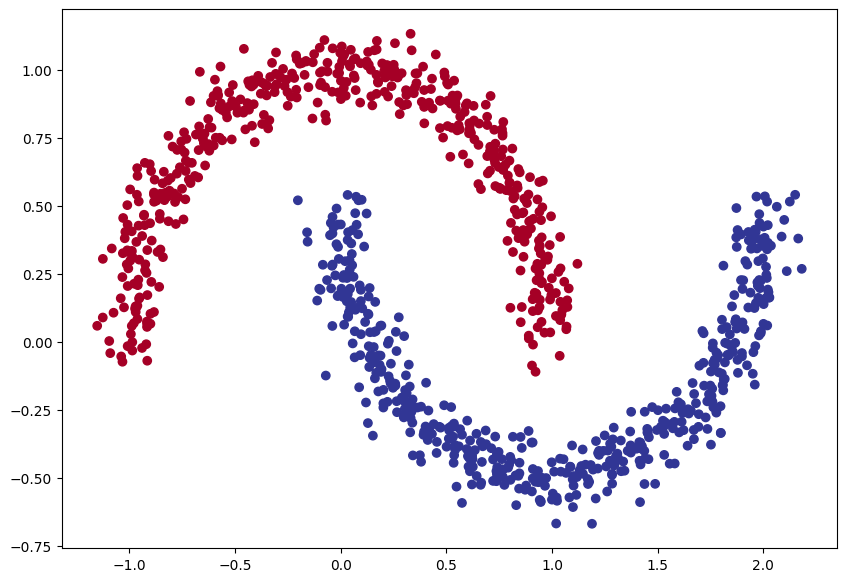

In [114]:
# Make a binary classification dataset with Scikit-Learn's make_moons() function.
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=1000, noise=0.07,random_state=RANDOM_SEED)


# 2. Turn data into tensors
X_moons = torch.from_numpy(X_moons).type(torch.float)
y_moons = torch.from_numpy(y_moons).type(torch.float)

# 3. Split into training and test
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(X_moons, y_moons, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_moons[:,0], X_moons[:,1], c=y_moons, cmap=plt.cm.RdYlBu)

In [115]:
len(X_moons_test), len(X_moons_train)

(200, 800)

In [116]:
class ExerciseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,10)
        self.layer2 = nn.Linear(10,10)
        self.layer3 = nn.Linear(10,1)
        self.relu = nn.ReLU()

    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

    
model = ExerciseModel().to(device=device)
model

ExerciseModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [117]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]], device='mps:0')),
             ('layer1.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642], device='mps:0')),
             ('layer2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.2663,  0

In [118]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [119]:
torch.manual_seed(seed=RANDOM_SEED)
epochs = 1000

X_moons_train, y_moons_train = X_moons_train.to(device), y_moons_train.to(device)
X_moons_test, y_moons_test = X_moons_test.to(device), y_moons_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_moons_train).squeeze()
    y_pred_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_pred_probs)

    loss = loss_fn(y_logits, y_moons_train)
    acc = accuracy_fn(y_pred, y_moons_train.int())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval() 
    with torch.inference_mode():
        test_logits = model(X_moons_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_moons_test)
        test_acc = accuracy_fn(test_pred, y_moons_test.int())

    if epoch % 100 == 0:
        model.eval()
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69015 | Accuracy: 50.00% | Test Loss: 0.68910 | Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.35754 | Accuracy: 86.62% | Test Loss: 0.37024 | Test Accuracy: 85.50%
Epoch: 200 | Loss: 0.22910 | Accuracy: 90.00% | Test Loss: 0.23071 | Test Accuracy: 91.00%
Epoch: 300 | Loss: 0.18338 | Accuracy: 91.88% | Test Loss: 0.17950 | Test Accuracy: 92.50%
Epoch: 400 | Loss: 0.13923 | Accuracy: 93.88% | Test Loss: 0.13481 | Test Accuracy: 94.00%
Epoch: 500 | Loss: 0.09523 | Accuracy: 96.50% | Test Loss: 0.09106 | Test Accuracy: 98.00%
Epoch: 600 | Loss: 0.06138 | Accuracy: 98.75% | Test Loss: 0.05778 | Test Accuracy: 98.50%
Epoch: 700 | Loss: 0.04082 | Accuracy: 99.50% | Test Loss: 0.03772 | Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02906 | Accuracy: 99.62% | Test Loss: 0.02632 | Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.02201 | Accuracy: 99.88% | Test Loss: 0.01953 | Test Accuracy: 100.00%


In [120]:
y_moons_test.dtype

torch.float32

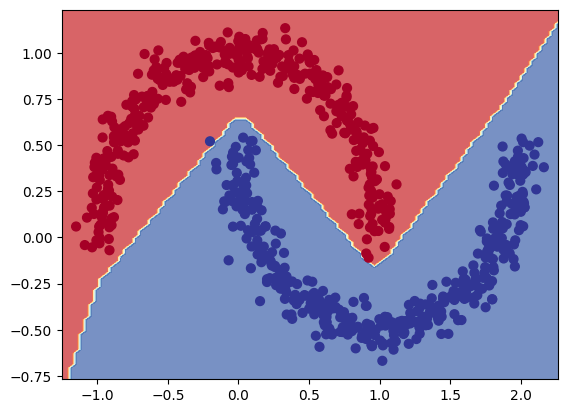

In [121]:
plot_decision_boundary(model=model, X=X_moons_train, y=y_moons_train)

In [122]:
# Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
def tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

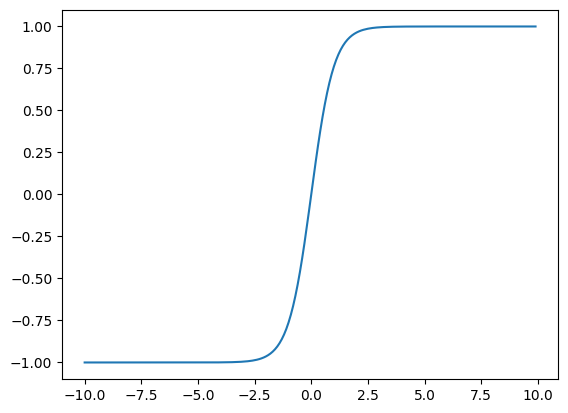

In [123]:
x = torch.arange(-10,10,0.1)
y = tanh(x)
plt.plot(x,y)

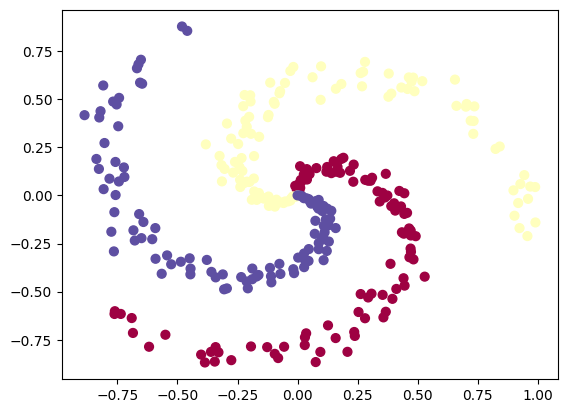

In [135]:
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [136]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [145]:
class Exercise2Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2,10)
        self.layer2 = nn.Linear(10,10)
        self.layer3 = nn.Linear(10,3)
        self.relu = nn.ReLU()
    
    def forward(self,x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    
model = Exercise2Model().to(device)
model

Exercise2Model(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [146]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.02)

In [152]:
torch.manual_seed(seed=RANDOM_SEED)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()

    y_logits = model(X_train)
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred = torch.argmax(y_pred_probs, dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval() 
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.argmax(torch.softmax(test_logits,dim=1), dim=1)
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_pred, y_test)

    if epoch % 100 == 0:
        model.eval()
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.11710 | Accuracy: 32.50% | Test Loss: 1.10461 | Test Accuracy: 36.67%
Epoch: 100 | Loss: 0.46245 | Accuracy: 75.83% | Test Loss: 0.60568 | Test Accuracy: 63.33%
Epoch: 200 | Loss: 0.18254 | Accuracy: 92.92% | Test Loss: 0.25068 | Test Accuracy: 93.33%
Epoch: 300 | Loss: 0.05069 | Accuracy: 99.17% | Test Loss: 0.02804 | Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.02678 | Accuracy: 99.17% | Test Loss: 0.00419 | Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.02270 | Accuracy: 99.17% | Test Loss: 0.00187 | Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.02058 | Accuracy: 99.17% | Test Loss: 0.00116 | Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.01917 | Accuracy: 99.17% | Test Loss: 0.00085 | Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.01811 | Accuracy: 99.17% | Test Loss: 0.00062 | Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.01731 | Accuracy: 99.17% | Test Loss: 0.00041 | Test Accuracy: 100.00%


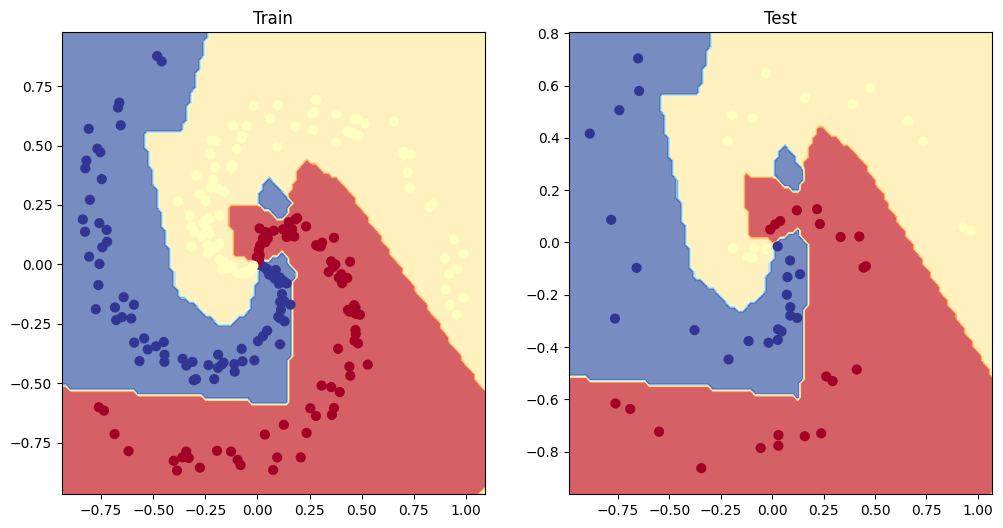

In [153]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)
     